<a href="https://colab.research.google.com/github/deltorobarba/machinelearning/blob/main/bigquery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BigQuery**

## bigquery stars

In [ ]:

import argparse
import numpy as np
import os

import pandas as pd
import tensorflow as tf

from google.cloud import bigquery
from google.cloud import storage

# Read environmental variables
training_data_uri = os.getenv("AIP_TRAINING_DATA_URI")
validation_data_uri = os.getenv("AIP_VALIDATION_DATA_URI")
test_data_uri = os.getenv("AIP_TEST_DATA_URI")

# Read args
parser = argparse.ArgumentParser()
parser.add_argument('--label_column', required=True, type=str)
parser.add_argument('--epochs', default=10, type=int)
parser.add_argument('--batch_size', default=10, type=int)
args = parser.parse_args()

# Set up training variables
LABEL_COLUMN = args.label_column

# See https://cloud.google.com/vertex-ai/docs/workbench/managed/executor#explicit-project-selection for issues regarding permissions.
PROJECT_NUMBER = os.environ["CLOUD_ML_PROJECT_ID"]
bq_client = bigquery.Client(project=PROJECT_NUMBER)


# Download a table
def download_table(bq_table_uri: str):
    # Remove bq:// prefix if present
    prefix = "bq://"
    if bq_table_uri.startswith(prefix):
        bq_table_uri = bq_table_uri[len(prefix) :]

    # Download the BigQuery table as a dataframe
    # This requires the "BigQuery Read Session User" role on the custom training service account.
    table = bq_client.get_table(bq_table_uri)
    return bq_client.list_rows(table).to_dataframe()

# Download dataset splits
df_train = download_table(training_data_uri)
df_validation = download_table(validation_data_uri)
df_test = download_table(test_data_uri)

def convert_dataframe_to_dataset(
    df_train: pd.DataFrame,
    df_validation: pd.DataFrame,
):
    df_train_x, df_train_y = df_train, df_train.pop(LABEL_COLUMN)
    df_validation_x, df_validation_y = df_validation, df_validation.pop(LABEL_COLUMN)

    y_train = tf.convert_to_tensor(np.asarray(df_train_y).astype("float32"))
    y_validation = tf.convert_to_tensor(np.asarray(df_validation_y).astype("float32"))

    # Convert to numpy representation
    x_train = tf.convert_to_tensor(np.asarray(df_train_x).astype("float32"))
    x_test = tf.convert_to_tensor(np.asarray(df_validation_x).astype("float32"))

    # Convert to one-hot representation
    num_species = len(df_train_y.unique())
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_species)
    y_validation = tf.keras.utils.to_categorical(y_validation, num_classes=num_species)

    dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    dataset_validation = tf.data.Dataset.from_tensor_slices((x_test, y_validation))
    return (dataset_train, dataset_validation)

# Create datasets
dataset_train, dataset_validation = convert_dataframe_to_dataset(df_train, df_validation)

# Shuffle train set
dataset_train = dataset_train.shuffle(len(df_train))

def create_model(num_features):
    # Create model
    Dense = tf.keras.layers.Dense
    model = tf.keras.Sequential(
        [
            Dense(
                100,
                activation=tf.nn.relu,
                kernel_initializer="uniform",
                input_dim=num_features,
            ),
            Dense(75, activation=tf.nn.relu),
            Dense(50, activation=tf.nn.relu),
            Dense(25, activation=tf.nn.relu),
            Dense(3, activation=tf.nn.softmax),
        ]
    )

    # Compile Keras model
    optimizer = tf.keras.optimizers.RMSprop(lr=0.001)
    model.compile(
        loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer
    )

    return model

# Create the model
model = create_model(num_features=dataset_train._flat_shapes[0].dims[0].value)

# Set up datasets
dataset_train = dataset_train.batch(args.batch_size)
dataset_validation = dataset_validation.batch(args.batch_size)

# Train the model
model.fit(dataset_train, epochs=args.epochs, validation_data=dataset_validation)

tf.saved_model.save(model, os.getenv("AIP_MODEL_DIR"))


In [ ]:
gsutil cp gs://cloud-training/cepf/cepf039/* ~/

gcloud ai endpoints list --region=us-west1


CREATE OR REPLACE MODEL dev_bqml.dev_star_model
OPTIONS(model_type='logistic_reg', input_label_cols=['Type']) AS
SELECT
    Temperature,
    L,
    R,
    A_M,
    Color,
    Spectral_Class,
    Type
  FROM
    `dev_bqml.dev_star_table`;





EXPORT MODEL `dev_bqml.dev_star_model`
OPTIONS(URI = 'gs://qwiklabs-gcp-00-7ca1bd0f8ac2-star/saved_model/')


gcloud ai models upload \
  --region=us-central1 \
  --display-name=dev-star-imported-model \
  --container-image-uri=us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-12:latest \
  --artifact-uri=gs://qwiklabs-gcp-00-cb10280fad85-star/saved_model/


gcloud ai models list --region=us-central1

gcloud ai endpoints create \
  --region=us-central1 \
  --display-name=dev-star-endpoint

## **Energy Forecasting**

#### **Import Data**

**Import from Github**

In [ ]:
import pandas as pd
url = 'https://raw.githubusercontent.com/deltorobarba/repo/master/entsoe.csv'
entsoe = pd.read_csv(url)
entsoe.head()

,Area,MTU,Biomass - Actual Aggregated [MW],Fossil Brown coal/Lignite - Actual Aggregated [MW],Fossil Coal-derived gas - Actual Aggregated [MW],Fossil Gas - Actual Aggregated [MW],Fossil Hard coal - Actual Aggregated [MW],Fossil Oil - Actual Aggregated [MW],Fossil Oil shale - Actual Aggregated [MW],Fossil Peat - Actual Aggregated [MW],...,Hydro Run-of-river and poundage - Actual Aggregated [MW],Hydro Water Reservoir - Actual Aggregated [MW],Marine - Actual Aggregated [MW],Nuclear - Actual Aggregated [MW],Other - Actual Aggregated [MW],Other renewable - Actual Aggregated [MW],Solar - Actual Aggregated [MW],Waste - Actual Aggregated [MW],Wind Offshore - Actual Aggregated [MW],Wind Onshore - Actual Aggregated [MW]
0,Germany (DE),01.01.2024 00:00 - 01.01.2024 00:15 (CET/CEST),4008,3353,n/e,2868,1855,398,n/e,n/e,...,1653,139,n/e,n/e,152,72,3,587,5839,29546
1,Germany (DE),01.01.2024 00:15 - 01.01.2024 00:30 (CET/CEST),4010,3477,n/e,2693,1863,398,n/e,n/e,...,1652,160,n/e,n/e,152,72,3,592,5748,29204
2,Germany (DE),01.01.2024 00:30 - 01.01.2024 00:45 (CET/CEST),4013,3379,n/e,2693,1856,398,n/e,n/e,...,1649,145,n/e,n/e,152,72,2,586,5618,29212
3,Germany (DE),01.01.2024 00:45 - 01.01.2024 01:00 (CET/CEST),4015,3358,n/e,2671,1869,398,n/e,n/e,...,1648,133,n/e,n/e,152,72,2,571,5512,29620
4,Germany (DE),01.01.2024 01:00 - 01.01.2024 01:15 (CET/CEST),3995,3362,n/e,2680,1863,398,n/e,n/e,...,1647,133,n/e,n/e,152,72,3,570,5464,29681


**Import from Google Storage**

In [ ]:
from google.colab import auth

auth.authenticate_user()

In [ ]:
!curl https://sdk.cloud.google.com | bash

In [ ]:
#!gsutil cp gs://bucket-name/entsoe.csv .

Copying gs://energy-lunar-352813/test.csv...
/ [1 files][  6.2 MiB/  6.2 MiB]                                                
Operation completed over 1 objects/6.2 MiB.                                      


In [ ]:
import pandas as pd
import io
df = pd.read_csv('entsoe.csv')
df.head()

,Area,MTU,Biomass - Actual Aggregated [MW],Fossil Brown coal/Lignite - Actual Aggregated [MW],Fossil Coal-derived gas - Actual Aggregated [MW],Fossil Gas - Actual Aggregated [MW],Fossil Hard coal - Actual Aggregated [MW],Fossil Oil - Actual Aggregated [MW],Fossil Oil shale - Actual Aggregated [MW],Fossil Peat - Actual Aggregated [MW],...,Hydro Run-of-river and poundage - Actual Aggregated [MW],Hydro Water Reservoir - Actual Aggregated [MW],Marine - Actual Aggregated [MW],Nuclear - Actual Aggregated [MW],Other - Actual Aggregated [MW],Other renewable - Actual Aggregated [MW],Solar - Actual Aggregated [MW],Waste - Actual Aggregated [MW],Wind Offshore - Actual Aggregated [MW],Wind Onshore - Actual Aggregated [MW]
0,Germany (DE),01.01.2024 00:00 - 01.01.2024 00:15 (CET/CEST),4008,3353,n/e,2868,1855,398,n/e,n/e,...,1653,139,n/e,n/e,152,72,3,587,5839,29546
1,Germany (DE),01.01.2024 00:15 - 01.01.2024 00:30 (CET/CEST),4010,3477,n/e,2693,1863,398,n/e,n/e,...,1652,160,n/e,n/e,152,72,3,592,5748,29204
2,Germany (DE),01.01.2024 00:30 - 01.01.2024 00:45 (CET/CEST),4013,3379,n/e,2693,1856,398,n/e,n/e,...,1649,145,n/e,n/e,152,72,2,586,5618,29212
3,Germany (DE),01.01.2024 00:45 - 01.01.2024 01:00 (CET/CEST),4015,3358,n/e,2671,1869,398,n/e,n/e,...,1648,133,n/e,n/e,152,72,2,571,5512,29620
4,Germany (DE),01.01.2024 01:00 - 01.01.2024 01:15 (CET/CEST),3995,3362,n/e,2680,1863,398,n/e,n/e,...,1647,133,n/e,n/e,152,72,3,570,5464,29681


**Upload from Laptop**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test.csv to test.csv


In [ ]:
import pandas as pd
import io
df = pd.read_csv(io.BytesIO(uploaded['entsoe.csv']))
df.head()

,Area,MTU,Biomass - Actual Aggregated [MW],Fossil Brown coal/Lignite - Actual Aggregated [MW],Fossil Coal-derived gas - Actual Aggregated [MW],Fossil Gas - Actual Aggregated [MW],Fossil Hard coal - Actual Aggregated [MW],Fossil Oil - Actual Aggregated [MW],Fossil Oil shale - Actual Aggregated [MW],Fossil Peat - Actual Aggregated [MW],...,Hydro Run-of-river and poundage - Actual Aggregated [MW],Hydro Water Reservoir - Actual Aggregated [MW],Marine - Actual Aggregated [MW],Nuclear - Actual Aggregated [MW],Other - Actual Aggregated [MW],Other renewable - Actual Aggregated [MW],Solar - Actual Aggregated [MW],Waste - Actual Aggregated [MW],Wind Offshore - Actual Aggregated [MW],Wind Onshore - Actual Aggregated [MW]
0,Germany (DE),01.01.2024 00:00 - 01.01.2024 00:15 (CET/CEST),4008,3353,n/e,2868,1855,398,n/e,n/e,...,1653,139,n/e,n/e,152,72,3,587,5839,29546
1,Germany (DE),01.01.2024 00:15 - 01.01.2024 00:30 (CET/CEST),4010,3477,n/e,2693,1863,398,n/e,n/e,...,1652,160,n/e,n/e,152,72,3,592,5748,29204
2,Germany (DE),01.01.2024 00:30 - 01.01.2024 00:45 (CET/CEST),4013,3379,n/e,2693,1856,398,n/e,n/e,...,1649,145,n/e,n/e,152,72,2,586,5618,29212
3,Germany (DE),01.01.2024 00:45 - 01.01.2024 01:00 (CET/CEST),4015,3358,n/e,2671,1869,398,n/e,n/e,...,1648,133,n/e,n/e,152,72,2,571,5512,29620
4,Germany (DE),01.01.2024 01:00 - 01.01.2024 01:15 (CET/CEST),3995,3362,n/e,2680,1863,398,n/e,n/e,...,1647,133,n/e,n/e,152,72,3,570,5464,29681


#### **Preprocess Data**

In [ ]:
rt = df
rt = rt.set_index('MTU') #.dropna(subset=(["rt"]))
rt = rt.rename_axis('time')
rt.head()

,Area,Biomass - Actual Aggregated [MW],Fossil Brown coal/Lignite - Actual Aggregated [MW],Fossil Coal-derived gas - Actual Aggregated [MW],Fossil Gas - Actual Aggregated [MW],Fossil Hard coal - Actual Aggregated [MW],Fossil Oil - Actual Aggregated [MW],Fossil Oil shale - Actual Aggregated [MW],Fossil Peat - Actual Aggregated [MW],Geothermal - Actual Aggregated [MW],...,Hydro Run-of-river and poundage - Actual Aggregated [MW],Hydro Water Reservoir - Actual Aggregated [MW],Marine - Actual Aggregated [MW],Nuclear - Actual Aggregated [MW],Other - Actual Aggregated [MW],Other renewable - Actual Aggregated [MW],Solar - Actual Aggregated [MW],Waste - Actual Aggregated [MW],Wind Offshore - Actual Aggregated [MW],Wind Onshore - Actual Aggregated [MW]
time,,,,,,,,,,,,,,,,,,,,,
01.01.2024 00:00 - 01.01.2024 00:15 (CET/CEST),Germany (DE),4008,3353,n/e,2868,1855,398,n/e,n/e,29,...,1653,139,n/e,n/e,152,72,3,587,5839,29546
01.01.2024 00:15 - 01.01.2024 00:30 (CET/CEST),Germany (DE),4010,3477,n/e,2693,1863,398,n/e,n/e,29,...,1652,160,n/e,n/e,152,72,3,592,5748,29204
01.01.2024 00:30 - 01.01.2024 00:45 (CET/CEST),Germany (DE),4013,3379,n/e,2693,1856,398,n/e,n/e,29,...,1649,145,n/e,n/e,152,72,2,586,5618,29212
01.01.2024 00:45 - 01.01.2024 01:00 (CET/CEST),Germany (DE),4015,3358,n/e,2671,1869,398,n/e,n/e,29,...,1648,133,n/e,n/e,152,72,2,571,5512,29620
01.01.2024 01:00 - 01.01.2024 01:15 (CET/CEST),Germany (DE),3995,3362,n/e,2680,1863,398,n/e,n/e,29,...,1647,133,n/e,n/e,152,72,3,570,5464,29681


In [ ]:
# Function to extract and format the start time
def format_time(time_str):
    start_time = time_str.split(" - ")[0]
    datetime_obj = pd.to_datetime(start_time, format="%d.%m.%Y %H:%M")
    return datetime_obj.strftime("%Y-%m-%d %H:%M:%S+00:00")

# Apply the function to the index
rt.index = rt.index.map(format_time)
rt.index = pd.to_datetime(rt.index, utc=True)
rt.head()

,Area,Biomass - Actual Aggregated [MW],Fossil Brown coal/Lignite - Actual Aggregated [MW],Fossil Coal-derived gas - Actual Aggregated [MW],Fossil Gas - Actual Aggregated [MW],Fossil Hard coal - Actual Aggregated [MW],Fossil Oil - Actual Aggregated [MW],Fossil Oil shale - Actual Aggregated [MW],Fossil Peat - Actual Aggregated [MW],Geothermal - Actual Aggregated [MW],...,Hydro Run-of-river and poundage - Actual Aggregated [MW],Hydro Water Reservoir - Actual Aggregated [MW],Marine - Actual Aggregated [MW],Nuclear - Actual Aggregated [MW],Other - Actual Aggregated [MW],Other renewable - Actual Aggregated [MW],Solar - Actual Aggregated [MW],Waste - Actual Aggregated [MW],Wind Offshore - Actual Aggregated [MW],Wind Onshore - Actual Aggregated [MW]
time,,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00+00:00,Germany (DE),4008,3353,n/e,2868,1855,398,n/e,n/e,29,...,1653,139,n/e,n/e,152,72,3,587,5839,29546
2024-01-01 00:15:00+00:00,Germany (DE),4010,3477,n/e,2693,1863,398,n/e,n/e,29,...,1652,160,n/e,n/e,152,72,3,592,5748,29204
2024-01-01 00:30:00+00:00,Germany (DE),4013,3379,n/e,2693,1856,398,n/e,n/e,29,...,1649,145,n/e,n/e,152,72,2,586,5618,29212
2024-01-01 00:45:00+00:00,Germany (DE),4015,3358,n/e,2671,1869,398,n/e,n/e,29,...,1648,133,n/e,n/e,152,72,2,571,5512,29620
2024-01-01 01:00:00+00:00,Germany (DE),3995,3362,n/e,2680,1863,398,n/e,n/e,29,...,1647,133,n/e,n/e,152,72,3,570,5464,29681


In [ ]:
rt = rt.drop(rt.columns[[0, 3, 7, 8, 14, 15]], axis=1)
rt.head()

,Biomass - Actual Aggregated [MW],Fossil Brown coal/Lignite - Actual Aggregated [MW],Fossil Gas - Actual Aggregated [MW],Fossil Hard coal - Actual Aggregated [MW],Fossil Oil - Actual Aggregated [MW],Geothermal - Actual Aggregated [MW],Hydro Pumped Storage - Actual Aggregated [MW],Hydro Pumped Storage - Actual Consumption [MW],Hydro Run-of-river and poundage - Actual Aggregated [MW],Hydro Water Reservoir - Actual Aggregated [MW],Other - Actual Aggregated [MW],Other renewable - Actual Aggregated [MW],Solar - Actual Aggregated [MW],Waste - Actual Aggregated [MW],Wind Offshore - Actual Aggregated [MW],Wind Onshore - Actual Aggregated [MW]
time,,,,,,,,,,,,,,,,
2024-01-01 00:00:00+00:00,4008,3353,2868,1855,398,29,1189,1588,1653,139,152,72,3,587,5839,29546
2024-01-01 00:15:00+00:00,4010,3477,2693,1863,398,29,435,2043,1652,160,152,72,3,592,5748,29204
2024-01-01 00:30:00+00:00,4013,3379,2693,1856,398,29,506,2454,1649,145,152,72,2,586,5618,29212
2024-01-01 00:45:00+00:00,4015,3358,2671,1869,398,29,353,2530,1648,133,152,72,2,571,5512,29620
2024-01-01 01:00:00+00:00,3995,3362,2680,1863,398,29,511,3199,1647,133,152,72,3,570,5464,29681


In [ ]:
rt = rt.rename(columns=lambda x: x.replace("[MW]", "- MW"))
rt.head()

,Biomass - Actual Aggregated - MW,Fossil Brown coal/Lignite - Actual Aggregated - MW,Fossil Gas - Actual Aggregated - MW,Fossil Hard coal - Actual Aggregated - MW,Fossil Oil - Actual Aggregated - MW,Geothermal - Actual Aggregated - MW,Hydro Pumped Storage - Actual Aggregated - MW,Hydro Pumped Storage - Actual Consumption - MW,Hydro Run-of-river and poundage - Actual Aggregated - MW,Hydro Water Reservoir - Actual Aggregated - MW,Other - Actual Aggregated - MW,Other renewable - Actual Aggregated - MW,Solar - Actual Aggregated - MW,Waste - Actual Aggregated - MW,Wind Offshore - Actual Aggregated - MW,Wind Onshore - Actual Aggregated - MW
time,,,,,,,,,,,,,,,,
2024-01-01 00:00:00+00:00,4008,3353,2868,1855,398,29,1189,1588,1653,139,152,72,3,587,5839,29546
2024-01-01 00:15:00+00:00,4010,3477,2693,1863,398,29,435,2043,1652,160,152,72,3,592,5748,29204
2024-01-01 00:30:00+00:00,4013,3379,2693,1856,398,29,506,2454,1649,145,152,72,2,586,5618,29212
2024-01-01 00:45:00+00:00,4015,3358,2671,1869,398,29,353,2530,1648,133,152,72,2,571,5512,29620
2024-01-01 01:00:00+00:00,3995,3362,2680,1863,398,29,511,3199,1647,133,152,72,3,570,5464,29681


In [ ]:
rt = rt.rename(columns=lambda x: x.replace("/", " "))
rt.head()

,Biomass - Actual Aggregated - MW,Fossil Brown coal Lignite - Actual Aggregated - MW,Fossil Gas - Actual Aggregated - MW,Fossil Hard coal - Actual Aggregated - MW,Fossil Oil - Actual Aggregated - MW,Geothermal - Actual Aggregated - MW,Hydro Pumped Storage - Actual Aggregated - MW,Hydro Pumped Storage - Actual Consumption - MW,Hydro Run-of-river and poundage - Actual Aggregated - MW,Hydro Water Reservoir - Actual Aggregated - MW,Other - Actual Aggregated - MW,Other renewable - Actual Aggregated - MW,Solar - Actual Aggregated - MW,Waste - Actual Aggregated - MW,Wind Offshore - Actual Aggregated - MW,Wind Onshore - Actual Aggregated - MW
time,,,,,,,,,,,,,,,,
2024-01-01 00:00:00+00:00,4008,3353,2868,1855,398,29,1189,1588,1653,139,152,72,3,587,5839,29546
2024-01-01 00:15:00+00:00,4010,3477,2693,1863,398,29,435,2043,1652,160,152,72,3,592,5748,29204
2024-01-01 00:30:00+00:00,4013,3379,2693,1856,398,29,506,2454,1649,145,152,72,2,586,5618,29212
2024-01-01 00:45:00+00:00,4015,3358,2671,1869,398,29,353,2530,1648,133,152,72,2,571,5512,29620
2024-01-01 01:00:00+00:00,3995,3362,2680,1863,398,29,511,3199,1647,133,152,72,3,570,5464,29681


In [ ]:
rt = rt.rename(columns=lambda x: x.replace(" - ", ""))
rt.head()

,Biomass Actual Aggregated MW,Fossil Brown coal Lignite Actual Aggregated MW,Fossil Gas Actual Aggregated MW,Fossil Hard coal Actual Aggregated MW,Fossil Oil Actual Aggregated MW,Geothermal Actual Aggregated MW,Hydro Pumped Storage Actual Aggregated MW,Hydro Pumped Storage Actual Consumption MW,Hydro Run-of-river and poundage Actual Aggregated MW,Hydro Water Reservoir Actual Aggregated MW,Other Actual Aggregated MW,Other renewable Actual Aggregated MW,Solar Actual Aggregated MW,Waste Actual Aggregated MW,Wind Offshore Actual Aggregated MW,Wind Onshore Actual Aggregated MW
time,,,,,,,,,,,,,,,,
2024-01-01 00:00:00+00:00,4008,3353,2868,1855,398,29,1189,1588,1653,139,152,72,3,587,5839,29546
2024-01-01 00:15:00+00:00,4010,3477,2693,1863,398,29,435,2043,1652,160,152,72,3,592,5748,29204
2024-01-01 00:30:00+00:00,4013,3379,2693,1856,398,29,506,2454,1649,145,152,72,2,586,5618,29212
2024-01-01 00:45:00+00:00,4015,3358,2671,1869,398,29,353,2530,1648,133,152,72,2,571,5512,29620
2024-01-01 01:00:00+00:00,3995,3362,2680,1863,398,29,511,3199,1647,133,152,72,3,570,5464,29681


In [ ]:
rt.tail()

,Biomass Actual Aggregated MW,Fossil Brown coal Lignite Actual Aggregated MW,Fossil Gas Actual Aggregated MW,Fossil Hard coal Actual Aggregated MW,Fossil Oil Actual Aggregated MW,Geothermal Actual Aggregated MW,Hydro Pumped Storage Actual Aggregated MW,Hydro Pumped Storage Actual Consumption MW,Hydro Run-of-river and poundage Actual Aggregated MW,Hydro Water Reservoir Actual Aggregated MW,Other Actual Aggregated MW,Other renewable Actual Aggregated MW,Solar Actual Aggregated MW,Waste Actual Aggregated MW,Wind Offshore Actual Aggregated MW,Wind Onshore Actual Aggregated MW
time,,,,,,,,,,,,,,,,
2024-09-16 08:30:00+00:00,4025,8380,6841,5037,364,21,5069,0,1781,505,179,82,2910,811,1342,10900
2024-09-16 08:45:00+00:00,3996,8429,6805,5053,364,21,4261,0,1779,490,179,82,3648,810,1490,10920
2024-09-16 09:00:00+00:00,3978,8511,6824,5061,364,21,5326,1,1778,519,179,82,4420,810,1736,10862
2024-09-16 09:15:00+00:00,3972,8567,6819,5060,364,21,4609,0,1773,420,179,82,5148,808,1985,10457
2024-09-16 09:30:00+00:00,3969,8599,6759,5068,364,21,3754,1,1771,321,179,82,5965,812,2014,10085


In [ ]:
rt_cleaned = rt.replace("-", float("NaN")).dropna()
# rt_cleaned = rt.loc[rt.index < '2024-09-16']
rt_cleaned.tail()

,Biomass Actual Aggregated MW,Fossil Brown coal Lignite Actual Aggregated MW,Fossil Gas Actual Aggregated MW,Fossil Hard coal Actual Aggregated MW,Fossil Oil Actual Aggregated MW,Geothermal Actual Aggregated MW,Hydro Pumped Storage Actual Aggregated MW,Hydro Pumped Storage Actual Consumption MW,Hydro Run-of-river and poundage Actual Aggregated MW,Hydro Water Reservoir Actual Aggregated MW,Other Actual Aggregated MW,Other renewable Actual Aggregated MW,Solar Actual Aggregated MW,Waste Actual Aggregated MW,Wind Offshore Actual Aggregated MW,Wind Onshore Actual Aggregated MW
time,,,,,,,,,,,,,,,,
2024-09-16 08:30:00+00:00,4025,8380,6841,5037,364,21,5069,0,1781,505,179,82,2910,811,1342,10900
2024-09-16 08:45:00+00:00,3996,8429,6805,5053,364,21,4261,0,1779,490,179,82,3648,810,1490,10920
2024-09-16 09:00:00+00:00,3978,8511,6824,5061,364,21,5326,1,1778,519,179,82,4420,810,1736,10862
2024-09-16 09:15:00+00:00,3972,8567,6819,5060,364,21,4609,0,1773,420,179,82,5148,808,1985,10457
2024-09-16 09:30:00+00:00,3969,8599,6759,5068,364,21,3754,1,1771,321,179,82,5965,812,2014,10085


In [ ]:
rt_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24852 entries, 2024-01-01 00:00:00+00:00 to 2024-09-16 09:30:00+00:00
Data columns (total 16 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   Biomass  Actual Aggregated MW                          24852 non-null  object
 1   Fossil Brown coal Lignite  Actual Aggregated MW        24852 non-null  object
 2   Fossil Gas  Actual Aggregated MW                       24852 non-null  object
 3   Fossil Hard coal  Actual Aggregated MW                 24852 non-null  object
 4   Fossil Oil  Actual Aggregated MW                       24852 non-null  object
 5   Geothermal  Actual Aggregated MW                       24852 non-null  object
 6   Hydro Pumped Storage  Actual Aggregated MW             24852 non-null  object
 7   Hydro Pumped Storage  Actual Consumption MW            24852 non-null  object
 8   Hydro Run

In [ ]:
rt = rt_cleaned
rt.head()

,Biomass - Actual Aggregated - MW,Fossil Brown coal Lignite - Actual Aggregated - MW,Fossil Gas - Actual Aggregated - MW,Fossil Hard coal - Actual Aggregated - MW,Fossil Oil - Actual Aggregated - MW,Geothermal - Actual Aggregated - MW,Hydro Pumped Storage - Actual Aggregated - MW,Hydro Pumped Storage - Actual Consumption - MW,Hydro Run-of-river and poundage - Actual Aggregated - MW,Hydro Water Reservoir - Actual Aggregated - MW,Other - Actual Aggregated - MW,Other renewable - Actual Aggregated - MW,Solar - Actual Aggregated - MW,Waste - Actual Aggregated - MW,Wind Offshore - Actual Aggregated - MW,Wind Onshore - Actual Aggregated - MW
time,,,,,,,,,,,,,,,,
2024-01-01 00:00:00+00:00,4008,3353,2868,1855,398,29,1189,1588,1653,139,152,72,3,587,5839,29546
2024-01-01 00:15:00+00:00,4010,3477,2693,1863,398,29,435,2043,1652,160,152,72,3,592,5748,29204
2024-01-01 00:30:00+00:00,4013,3379,2693,1856,398,29,506,2454,1649,145,152,72,2,586,5618,29212
2024-01-01 00:45:00+00:00,4015,3358,2671,1869,398,29,353,2530,1648,133,152,72,2,571,5512,29620
2024-01-01 01:00:00+00:00,3995,3362,2680,1863,398,29,511,3199,1647,133,152,72,3,570,5464,29681


#### **Send to BigQuery**

https://cloud.google.com/vertex-ai/docs/workbench/instances/bigquery

In [ ]:
!pip install google-cloud-bigquery -q

In [ ]:
import google.auth
print(google.auth.default())

(<google.auth.compute_engine.credentials.Credentials object at 0x7d73b878edd0>, 'lunar-352813')


In [ ]:
project_id = 'your-project'

In [ ]:
from google.cloud import bigquery

# Replace 'your-project-id' with your Google Cloud project ID
client = bigquery.Client(project=project_id)

In [ ]:
dataset_id = 'energy'
table_id = 'entsoe'

In [ ]:
# Configure upload to BigQuery
job_config = bigquery.LoadJobConfig(
    write_disposition="WRITE_TRUNCATE",
)
table_ref = client.dataset(dataset_id).table(table_id)

# Load data to BigQuery
job = client.load_table_from_dataframe(rt, table_ref, job_config=job_config)
job.result()  # Wait for the job to complete

print(f"Loaded    {rt.shape[0]} rows and {rt.shape[1]} columns to BigQuery table: {project_id}:{dataset_id}.{table_id}")

Loaded    24852 rows and 16 columns to BigQuery table: lunar-352813:energy.entsoe


In [ ]:
# Example query: Replace 'your_dataset' and 'your_table' with your actual dataset and table names
query = """
    SELECT *
    FROM `your-project.energy.entsoe`
    LIMIT 10
"""

# Run the query and convert the result to a DataFrame
query_job = client.query(query)
df = query_job.to_dataframe()

# Show the first few rows of the dataframe
df.head()

,time,Biomass Actual Aggregated MW,Fossil Brown coal Lignite Actual Aggregated MW,Fossil Gas Actual Aggregated MW,Fossil Hard coal Actual Aggregated MW,Fossil Oil Actual Aggregated MW,Geothermal Actual Aggregated MW,Hydro Pumped Storage Actual Aggregated MW,Hydro Pumped Storage Actual Consumption MW,Hydro Run-of-river and poundage Actual Aggregated MW,Hydro Water Reservoir Actual Aggregated MW,Other Actual Aggregated MW,Other renewable Actual Aggregated MW,Solar Actual Aggregated MW,Waste Actual Aggregated MW,Wind Offshore Actual Aggregated MW,Wind Onshore Actual Aggregated MW
0,2024-01-01 00:00:00+00:00,4008,3353,2868,1855,398,29,1189,1588,1653,139,152,72,3,587,5839,29546
1,2024-01-01 00:15:00+00:00,4010,3477,2693,1863,398,29,435,2043,1652,160,152,72,3,592,5748,29204
2,2024-01-01 00:30:00+00:00,4013,3379,2693,1856,398,29,506,2454,1649,145,152,72,2,586,5618,29212
3,2024-01-01 00:45:00+00:00,4015,3358,2671,1869,398,29,353,2530,1648,133,152,72,2,571,5512,29620
4,2024-01-01 01:00:00+00:00,3995,3362,2680,1863,398,29,511,3199,1647,133,152,72,3,570,5464,29681


#### **Generative AI (BigQuery Analytics)**

In [ ]:
# Example query: Replace 'your_dataset' and 'your_table' with your actual dataset and table names
query = """
    SELECT time, "Biomass Actual Aggregated MW"
    FROM `lunar-352813.energy.entsoe`
    LIMIT 10
"""

# Run the query and convert the result to a DataFrame
query_job = client.query(query)
df = query_job.to_dataframe()

# Show the first few rows of the dataframe
df.head()

,time,f0_
0,2024-01-01 00:00:00+00:00,Biomass Actual Aggregated MW
1,2024-01-01 00:15:00+00:00,Biomass Actual Aggregated MW
2,2024-01-01 00:30:00+00:00,Biomass Actual Aggregated MW
3,2024-01-01 00:45:00+00:00,Biomass Actual Aggregated MW
4,2024-01-01 01:00:00+00:00,Biomass Actual Aggregated MW


In [ ]:
import vertexai

In [ ]:
project_id = "your-project"

vertexai.init(project=project_id, location="us-central1")

system_instruction = """
"""

In [ ]:
from google.cloud import bigquery

# Construct a BigQuery client object.
client = bigquery.Client()

# Example query (replace with your own)
query = """
SELECT
    time,
    Biomass - Actual Aggregated - MW,
    Fossil Oil - Actual Aggregated - MW
  FROM
    `lunar-352813`.energy.entsoe
  ORDER BY
    time DESC;
  LIMIT
    10;

"""

# Run the query and convert results to a Pandas DataFrame
query_job = client.query(query)
df = query_job.to_dataframe()

# Print the results
print(df.head())

BadRequest: 400 Syntax error: Expected end of input but got "-" at [4:33]; reason: invalidQuery, location: query, message: Syntax error: Expected end of input but got "-" at [4:33]

Location: US
Job ID: 1eebf2b2-c394-4265-8954-959458133ad9


In [ ]:
# (Simplified) Prompt-to-SQL translation (replace with your logic)
def translate_prompt(prompt):
  if "top 10 times by Biomass - Actual Aggregated - MW" in prompt.lower():
    sql_query = """
        SELECT customer_name, SUM(order_amount) AS total_revenue
        FROM `your_project.your_dataset.your_table`
        GROUP BY customer_name
        ORDER BY total_revenue DESC
        LIMIT 10
    """
    return sql_query
  else:
    return "I don't understand that prompt yet."

# Get user prompt
user_prompt = input("what are the top 10 times by Biomass - Actual Aggregated - MW?")
sql_query = translate_prompt(user_prompt)
print(sql_query)

# Execute query and display results (if valid SQL)
if "SELECT" in sql_query:
  query_job = client.query(sql_query)
  results = query_job.result()
  df = results.to_dataframe()
  print(df)

#### **Other BQ dataset**

In [ ]:
from google.cloud import bigquery

# Construct a BigQuery client object.
client = bigquery.Client()

# Example query (replace with your own)
query = """
SELECT
    SendingTime,
    TradeDate,
    StrikePrice
  FROM
    `bigquery-public-data`.cymbal_investments.trade_capture_report
  ORDER BY
    TradeDate;


"""

# Run the query and convert results to a Pandas DataFrame
query_job = client.query(query)
df = query_job.to_dataframe()

# Print the results
print(df.head())

                SendingTime   TradeDate  StrikePrice
0 2020-05-18 17:51:23+00:00  2020-05-18     2950.625
1 2020-05-18 17:56:48+00:00  2020-05-18     2952.875
2 2020-05-18 18:03:14+00:00  2020-05-18     2955.375
3 2020-05-18 18:26:05+00:00  2020-05-18     2953.625
4 2020-05-18 18:31:20+00:00  2020-05-18     2954.625


## **IIoT Telemetry**

**Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

**Set Constants**

In [ ]:
PROJECT = 'lunar-demo'
BUCKET = 'manufacturing-demo'

*Following code is not necessary if the notebook runs as Jupyterlab on GCP Managed Notebooks*

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


### **Load Data**


**Load Data from Google Cloud Storage**

In [ ]:
# !gsutil cp gs://BUCKET/telemetryfeat.csv .

**Load Data from Github**

In [ ]:
# url = 'https://raw.githubusercontent.com/......csv'
# series_raw = pd.read_csv(url)
# series_raw.head()

**In this case: Load Data from BigQuery**

In [ ]:
_IOT_PROJECT_NAME = u"PROJECT" #"lunar-demo"

def run_iot_query(query, index_col="datetime"):
  return pd.read_gbq(
    query,
    project_id=PROJECT, #_IOT_PROJECT_NAME,
    index_col=index_col,
    dialect="standard").sort_index()

time: 1.8 ms


In [ ]:
def run_iot_query(query, index_col="datetime"):
  return pd.read_gbq(
    query,
    project_id=PROJECT,
    index_col=index_col,
    dialect="standard").sort_index()

In [ ]:
# 'telemetryfeat'
telemetryfeat_raw = run_iot_query(
    "SELECT * FROM `lunar-demo.manufacturing.telemetryfeat` order by datetime asc")

time: 48.3 s


In [ ]:
# Upload total 'raw' table data to BigQuery
#!pip install --quiet ipython-autotime pandas_gbq
#%load_ext autotime
#project_id = !gcloud config get-value project
#telemetryfeat.to_gbq('manufacturing.telemetryfeat2', project_id=project_id[0])

### **Preprocess Data**

**Copy and display 'raw' data**

In [ ]:
telemetryfeat = telemetryfeat_raw
telemetryfeat.head()

,machineID,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd
datetime,,,,,,,,,
2015-01-02 05:00:00+00:00,1,169.733809,445.179865,96.797113,40.385160,11.233120,48.717395,10.079880,5.853209
2015-01-02 05:00:00+00:00,2,172.096089,442.804046,97.369279,41.970373,11.358840,41.038841,11.003220,4.569906
2015-01-02 05:00:00+00:00,3,170.066825,460.956803,101.395264,37.989643,12.133703,50.054464,10.831107,5.845904
2015-01-02 05:00:00+00:00,4,170.116871,440.333823,98.378607,42.106068,16.607902,49.172579,8.282528,4.833216
2015-01-02 05:00:00+00:00,5,175.674631,460.621226,97.928488,38.591031,14.915482,60.620670,10.824448,4.355144


time: 28.3 ms


We can filter data in two dimension: either all sensors for one machine, or data from one sensor on all machines. We will do both.

**Option 1: Choose one Sensor over all Machines**

('Unmelt' table for one feature only and list per Machine ID)

In [ ]:
voltmean = telemetryfeat.reset_index()
voltmean = voltmean[['datetime', 'machineID', 'voltmean']]
voltmean = pd.pivot_table(voltmean, values='voltmean', index=['datetime'], columns=['machineID'])
voltmean = voltmean.dropna(axis='columns')
# Adding a prefix, since we cannot work with values starting with numbers in columns
voltmean = voltmean.add_prefix('m_')
voltmean

machineID,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,m_13,m_14,m_15,m_16,m_17,m_18,m_19,m_20,m_21,m_22,m_23,m_24,m_25,m_26,m_27,m_28,m_29,m_30,m_31,m_32,m_33,m_34,m_35,m_36,m_37,m_38,m_39,m_40,...,m_61,m_62,m_63,m_64,m_65,m_66,m_67,m_68,m_69,m_70,m_71,m_72,m_73,m_74,m_75,m_76,m_77,m_78,m_79,m_80,m_81,m_82,m_83,m_84,m_85,m_86,m_87,m_88,m_89,m_90,m_91,m_92,m_93,m_94,m_95,m_96,m_97,m_98,m_99,m_100
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02 05:00:00+00:00,169.733809,172.096089,170.066825,170.116871,175.674631,166.444305,173.004557,170.045926,179.657731,169.200172,164.741691,171.270988,169.970005,173.189275,166.417580,191.871024,171.468694,171.765752,168.205151,173.353001,170.276913,190.264744,172.828494,187.723832,170.691748,169.328150,167.851591,173.231944,169.752148,168.712114,172.979357,170.708318,170.154521,169.865096,188.672045,166.501343,168.190381,172.242765,172.009649,167.240163,...,176.344493,165.228217,170.603095,170.358178,174.637119,174.224002,173.060071,170.810184,170.162954,166.019457,172.590303,170.299151,168.980141,169.591922,171.143752,190.002605,188.360502,176.130127,193.420322,167.253685,184.475804,173.821670,162.870428,169.271596,188.893514,187.798329,189.155561,171.272390,169.098596,166.800672,172.677564,170.560444,170.496339,165.811714,176.024427,174.305445,168.734298,168.697828,169.486659,170.666511
2015-01-02 08:00:00+00:00,170.525721,171.510408,167.193146,170.145327,174.725997,169.709845,173.815784,171.351848,177.537748,167.467301,167.238640,168.773385,169.701752,173.023964,167.947157,189.572599,171.330965,168.406596,167.748800,173.277823,169.467766,187.150476,173.293855,185.664597,171.385796,170.917803,169.382573,170.593636,169.610822,169.733538,175.210958,168.987179,170.780366,167.611445,185.964376,165.691188,166.571534,171.514373,174.236984,169.531580,...,175.683884,165.740415,172.922112,171.517177,176.058853,169.906390,171.727756,171.031611,171.084421,166.369161,171.666598,171.814394,169.682178,169.390112,170.565775,190.489502,188.172242,176.008049,189.404389,167.955157,183.615737,174.037891,164.286219,168.370918,189.648652,186.238975,187.506576,172.764402,170.632881,167.267586,173.245011,172.299821,171.713525,164.558632,175.915434,173.241995,170.815997,168.385422,170.506146,171.483121
2015-01-02 11:00:00+00:00,170.049722,170.840565,169.120617,168.985282,175.639031,169.141877,176.160444,170.441943,177.052348,167.100570,169.986155,168.937600,169.790426,171.268018,169.919876,186.702246,170.484168,170.003905,169.917410,171.646778,169.991403,186.852853,172.265012,181.542389,174.330731,169.557792,171.460182,169.935215,171.330160,168.440363,174.755372,170.266103,172.369427,166.845230,183.416156,166.660960,164.571389,171.075532,171.764955,171.840124,...,174.126146,165.516460,171.121785,172.802321,175.764846,169.976394,171.839062,170.161286,171.389791,167.514414,172.423480,169.934388,170.541174,171.448346,171.790142,192.727544,190.236368,173.580464,186.389742,167.804554,178.072996,172.020246,165.153784,165.037185,187.305173,184.045171,184.581167,171.631008,169.251577,168.131236,174.782505,169.155851,171.716567,163.036201,176.068521,172.957382,171.573747,169.312676,171.650582,171.841317
2015-01-02 14:00:00+00:00,170.341974,170.736634,170.667376,167.216339,174.371977,171.511405,175.918266,171.948016,175.673448,165.237155,171.087036,168.281489,171.048564,171.121428,170.309861,184.683599,171.313695,173.549958,171.159721,170.916219,171.106664,185.335714,171.321984,178.982294,173.675761,166.081989,173.299342,168.778537,172.377893,169.424057,175.737290,168.972573,171.644324,170.239779,181.189321,164.178803,168.015657,171.906278,169.500157,169.818487,...,171.007004,165.115108,171.314782,173.536691,177.939550,168.838739,171.286349,170.046526,172.707942,167.433688,171.655455,168.986787,170.155979,168.983852,169.953694,194.770258,192.168839,174.937861,182.522220,170.486287,176.578671,169.016398,165.107826,166.091467,187.936163,181.395605,179.956501,174.806

time: 354 ms


**Option 2: Choose one Machine and show all Sensor Records on it**

In [ ]:
machine_1 = telemetryfeat[(telemetryfeat.machineID == 1)]
# Normally we can drop the machine ID column, but we will need it for AutoML Forecasting,so we keep it
# machine_1 = machine_1.drop(columns=['machineID']).sort_index(ascending=True)
machine_1

,machineID,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd
datetime,,,,,,,,,
2015-01-02 05:00:00+00:00,1,169.733809,445.179865,96.797113,40.385160,11.233120,48.717395,10.079880,5.853209
2015-01-02 08:00:00+00:00,1,170.525721,443.906847,97.667249,39.786670,12.591948,46.930282,9.406795,6.098173
2015-01-02 11:00:00+00:00,1,170.049722,446.461279,96.906162,40.016513,13.277336,42.836780,9.071472,5.481724
2015-01-02 14:00:00+00:00,1,170.341974,447.355315,96.229522,39.921963,13.817158,42.808633,8.256794,5.862312
2015-01-02 17:00:00+00:00,1,170.060643,452.163407,96.357441,39.990470,14.792869,42.525293,8.669605,5.907157
...,...,...,...,...,...,...,...,...,...
2015-12-31 17:00:00+00:00,1,171.349634,452.416132,99.748116,39.655997,14.236322,65.731722,8.891385,4.795727
2015-12-31 20:00:00+00:00,1,171.106776,448.747625,99.509456,39.416218,12.086360,66.209673,9.097349,5.535579
2015-12-31 23:00:00+00:00,1,168.463155,449.732664,98.636486,38.642038,12.447174,64.707424,10.294397,5.160023


time: 33 ms


**Add Columns for BigQuery Classification and AutoML Forecasting**

In [ ]:
# AutoML Forecasting requires a constant per table, but witrh this dataset it is not necessary
# machine_1['unique_id'] = '42'
# machine_1.head()

**Add a classification component and classifier (for example we want to predict 'voltmean')**

In [ ]:
machine_1['delta'] = machine_1.voltmean.diff()
machine_1 = machine_1.dropna()
machine_1['classifier'] = machine_1['delta']
machine_1 = machine_1.drop(columns=['delta'])
machine_1['classifier'].values[machine_1['classifier'] < 0] = 0
machine_1['classifier'].values[machine_1['classifier'] > 0] = 1
machine_1.head()

,machineID,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,classifier
datetime,,,,,,,,,,
2015-01-02 14:00:00+00:00,1,170.341974,447.355315,96.229522,39.921963,13.817158,42.808633,8.256794,5.862312,1.0
2015-01-02 17:00:00+00:00,1,170.060643,452.163407,96.357441,39.990470,14.792869,42.525293,8.669605,5.907157,0.0
2015-01-02 20:00:00+00:00,1,169.369283,453.336163,98.042007,39.531667,15.674787,41.689624,10.607947,6.205887,0.0
2015-01-02 23:00:00+00:00,1,169.795758,446.832666,98.454608,39.271645,15.742155,38.800266,11.679314,5.579524,1.0
2015-01-03 02:00:00+00:00,1,170.162325,450.221017,100.880519,38.838137,15.801770,40.490000,11.323930,5.565239,1.0


time: 35 ms


### **Load Data to BigQuery**

We will be working with data from one machine.

In [ ]:
# Reset index to properly save datetime data in BigQuery
machine_1 = machine_1.reset_index()

time: 2.49 ms


In [ ]:
# Allow connection to BigQuery
!pip install --quiet ipython-autotime pandas_gbq
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.24 s


In [ ]:
# Upload filtered data to BigQuery
machine_1.to_gbq('manufacturing.machine_1', project_id=PROJECT)

1it [00:03,  3.07s/it]

time: 5.47 s


### **Analyse Data**

**We have 8 sensor data from different machines pder each time stamp. How many machines are there?**

In [ ]:
telemetryfeat.machineID.unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

time: 5.9 ms


In [ ]:
telemetryfeat['machineID'].nunique()

100

time: 4.98 ms


There are records from 100 machines.

**What is the time span? (until when do we have data?)**

In [ ]:
telemetryfeat.tail()

,machineID,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd
datetime,,,,,,,,,
2016-01-01 05:00:00+00:00,96,168.737340,448.451423,102.010456,40.591368,17.863243,44.241511,10.602169,4.791980
2016-01-01 05:00:00+00:00,97,174.066698,462.606664,95.378736,40.668871,10.645043,47.928761,10.701270,5.131409
2016-01-01 05:00:00+00:00,98,170.146868,444.604801,125.024957,40.661580,17.398373,50.000901,9.436988,4.244810
2016-01-01 05:00:00+00:00,99,168.689830,457.549855,100.864715,40.882592,15.854221,45.155521,7.063937,5.008058
2016-01-01 05:00:00+00:00,100,173.872030,455.376558,101.447889,40.261609,15.564393,61.308632,8.835047,6.171566


time: 24.8 ms


We have data from 2015-01-02 until 2016-01-01.

**Are there any missing data?**

In [ ]:
telemetryfeat.apply(lambda x: sum(x.isnull()),axis=0)

machineID        0
voltmean         0
rotatemean       0
pressuremean     0
vibrationmean    0
voltsd           0
rotatesd         0
pressuresd       0
vibrationsd      0
dtype: int64

time: 226 ms


No missing data. Series is (atypically) very clean.

**How many records do we have?**

In [ ]:
telemetryfeat.describe()

,machineID,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd
count,291300.00000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000,291300.000000
mean,50.50000,170.772380,446.613387,100.854549,40.384528,14.918992,49.947267,10.047051,5.001975
std,28.86612,4.716899,18.073481,4.733546,2.059801,2.260848,7.689803,1.712238,0.799431
min,1.00000,156.284729,267.008131,90.352636,35.253276,6.502826,19.839519,4.433238,2.107598
25%,25.75000,168.068540,441.572806,98.670051,39.357556,13.358201,44.667738,8.924565,4.461158
50%,50.50000,170.209615,449.198555,100.098070,40.070423,14.855999,49.614839,9.922168,4.958120
75%,75.25000,172.454059,456.369858,101.613625,40.832048,16.396254,54.802211,10.981186,5.484147
max,100.00000,220.569064,499.288786,152.660905,61.852838,27.914053,105.326445,28.867737,12.609035


time: 146 ms


We have 291,300 records for each feature. Given that we have 100 sensors this means we have 2,913 records per machine and sensor (feature). But let's extract the values from one sensor for all 100 machines to see that a bit more in detail:

**Do they values fluctuate a lot per machine, or are they similar?**

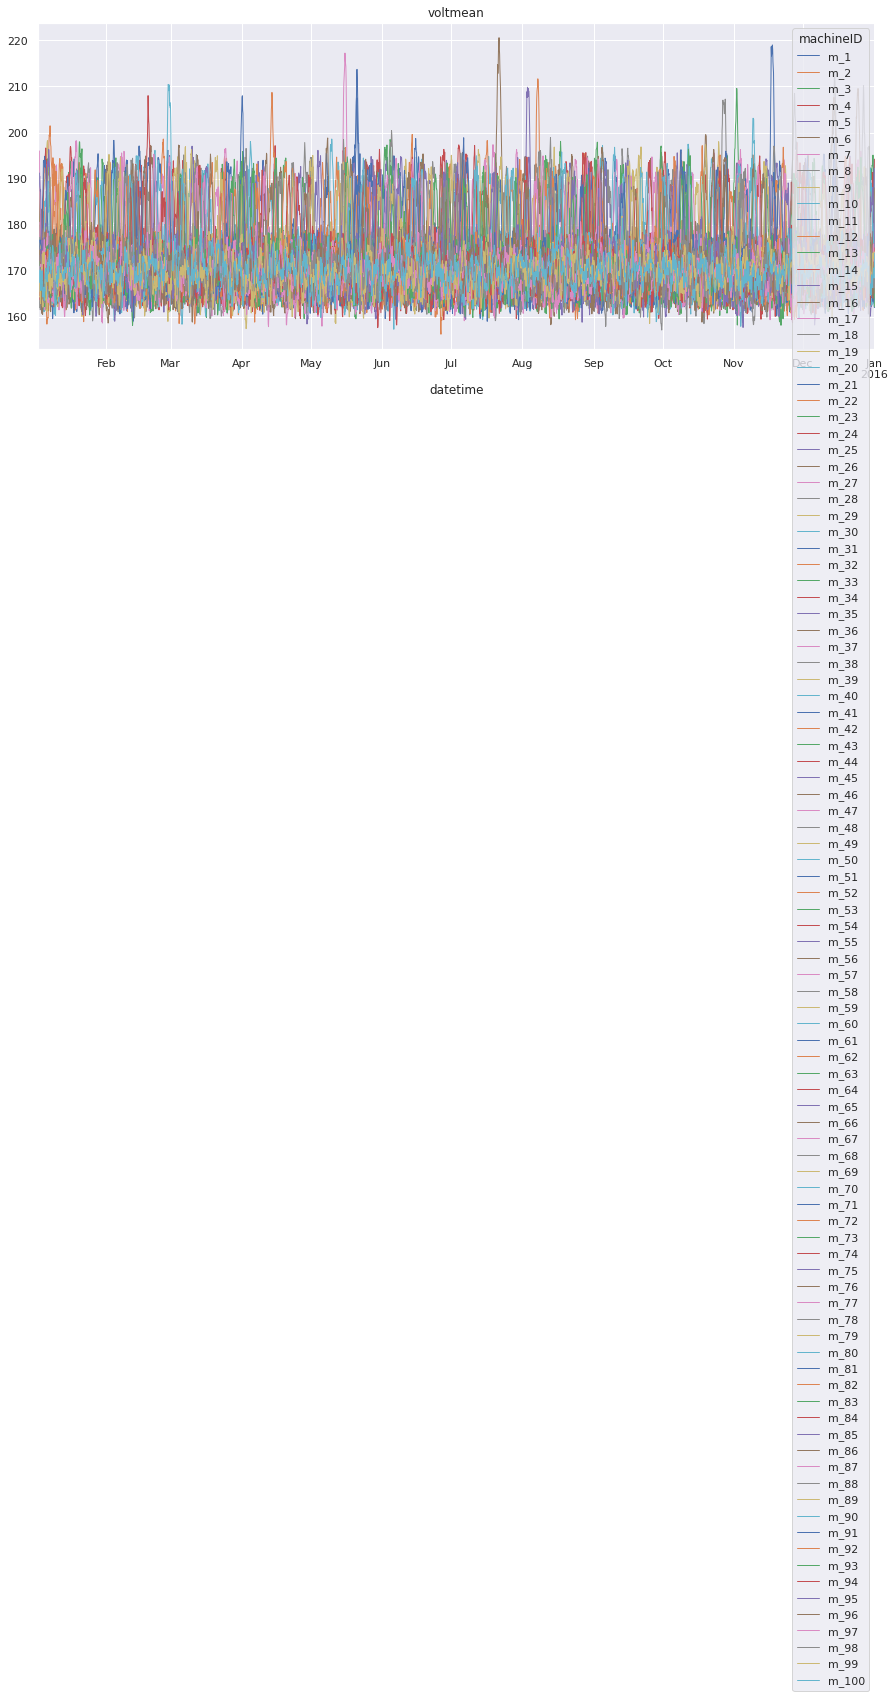

time: 5.35 s


In [ ]:
sns.set(rc={'figure.figsize':(15, 6)})
voltmean.plot(linewidth=1.0,title='voltmean')

Let's have a look at rhe sensor records at a single machine (m_1 and m_100):

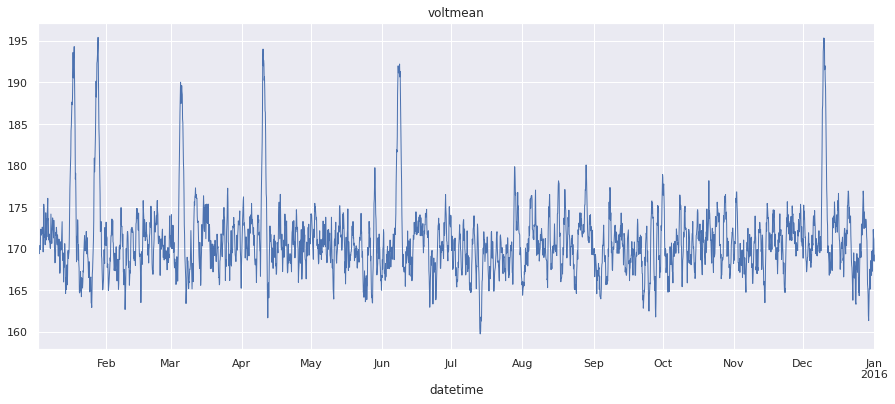

time: 959 ms


In [ ]:
sns.set(rc={'figure.figsize':(15, 6)})
voltmean.m_1.plot(linewidth=1.0,title='voltmean')

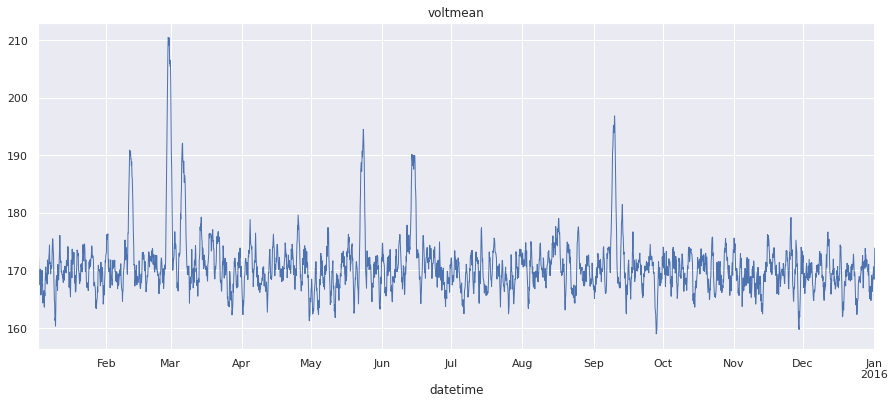

time: 922 ms


In [ ]:
sns.set(rc={'figure.figsize':(15, 6)})
voltmean.m_100.plot(linewidth=1.0,title='voltmean')

Sensor values fluctuate a lot looking at different machines. Might be worthful knowing why.
That brings us to the next question regarding data distribution

**What is the data distribution over all 100 machines for one feature?**

Distribution for the one feature over all 100 machines:

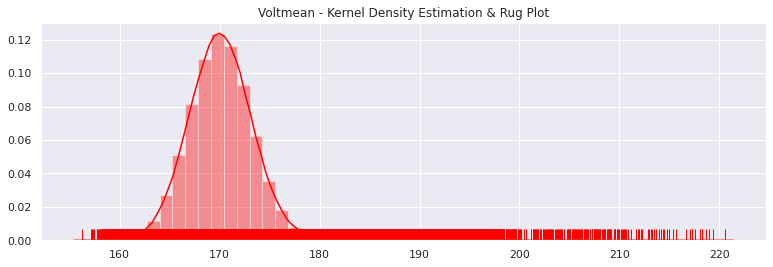

time: 3.09 s


In [ ]:
sns.set(rc={'figure.figsize':(13, 4)})
sns.distplot((voltmean), hist=True, rug=True, color ='red').set_title('Voltmean - Kernel Density Estimation & Rug Plot')
plt.show()

Distribution for the one feature for one machines (#1):

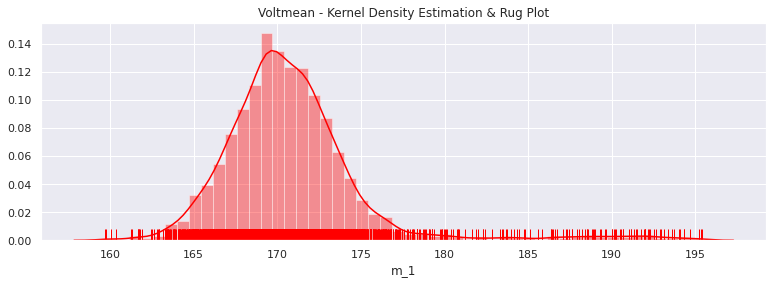

time: 413 ms


In [ ]:
sns.set(rc={'figure.figsize':(13, 4)})
sns.distplot((voltmean.m_1), hist=True, rug=True, color ='red').set_title('Voltmean - Kernel Density Estimation & Rug Plot')
plt.show()

**Autocorrelation Plot for selected feature on one machine**

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


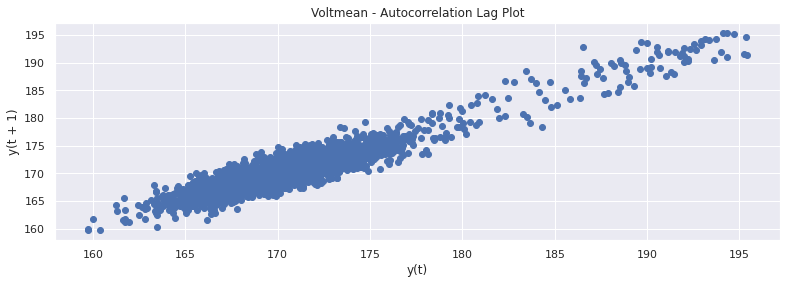

time: 292 ms


In [ ]:
from pandas.plotting import lag_plot
lag_plot(voltmean.m_1)
plt.title('Voltmean - Autocorrelation Lag Plot')
plt.show()

Typically for time series: the most recent time steps has a strong influence on the current value.

Let's have a look at previous time steps' influence on the current value:

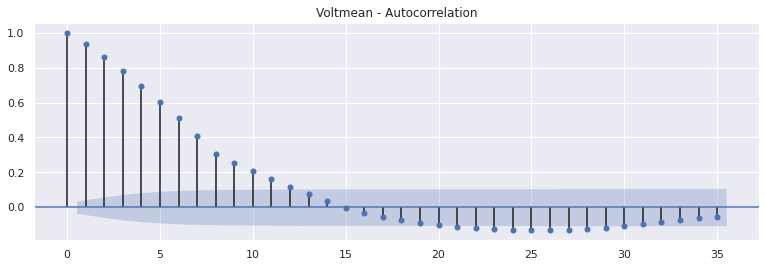

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(voltmean.m_1)
plt.title('Voltmean - Autocorrelation')
plt.show()

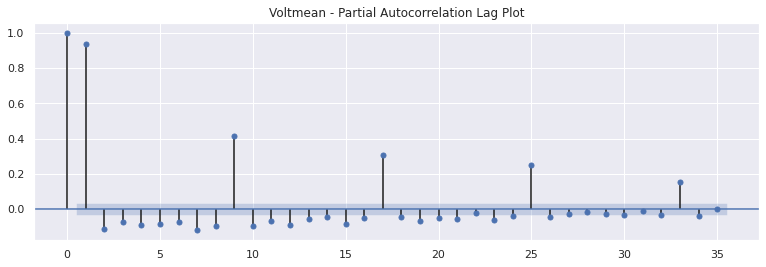

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(voltmean.m_1)
plt.title('Voltmean - Partial Autocorrelation Lag Plot')
plt.show()

There is an interesting pattern: every past 8 time steps (each 8 hours) have an influence on the current value. Domain knowledge might reveal the reason for this behavior, but 24h seems to reflect machine on/off cycles or similar.

**Visualize Sensor as Time Series Plot**

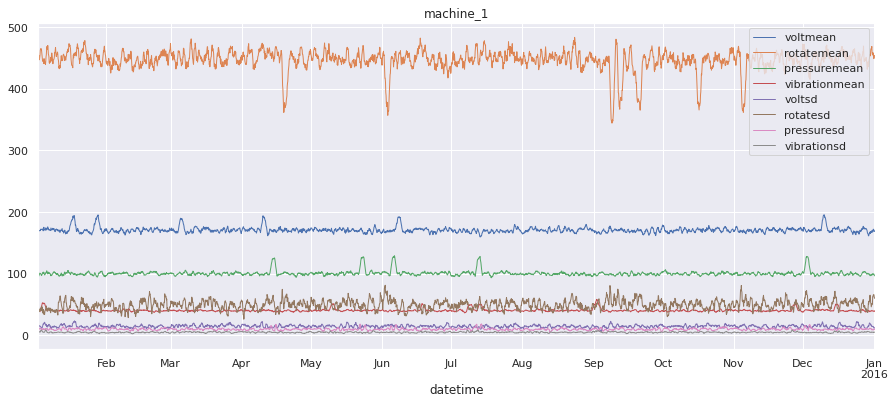

time: 1.19 s


In [ ]:
# Remove machineID column
df = machine_1.drop(columns=['machineID', 'classifier'])
# Display all sensor data for machine 1
sns.set(rc={'figure.figsize':(15, 6)})
df.plot(linewidth=1.0,title='machine_1')

### **Train & Evaluate Model**

#### **Regression on BigQuery**

Let's create an Arima model for sensor 'voltmean' on machine 1

In [ ]:
%%bigquery
CREATE MODEL `lunar-demo.manufacturing.arima`
 OPTIONS(MODEL_TYPE='ARIMA',
         time_series_timestamp_col='datetime',
         time_series_data_col='voltmean') AS
SELECT
  datetime,
  voltmean
FROM
  `manufacturing.machine_1`

In [ ]:
%%bigquery
SELECT *
FROM ML.ARIMA_COEFFICIENTS(MODEL manufacturing.arima)

In [ ]:
%%bigquery
SELECT *
FROM ML.EVALUATE(MODEL manufacturing.arima)

In [ ]:
%%bigquery
SELECT *
FROM ML.TRAINING_INFO(MODEL manufacturing.arima)

#### **Classification on BigQuery**

In [ ]:
%%bigquery
CREATE OR REPLACE MODEL
  `manufacturing.log_reg`
OPTIONS
  ( model_type='LOGISTIC_REG',
    auto_class_weights=TRUE,
    input_label_cols=['classifier']
  ) AS
SELECT
  *
FROM
  `manufacturing.classification`

In [ ]:
%%bigquery
SELECT *
FROM ML.EVALUATE(MODEL manufacturing.log_reg)

In [ ]:
%%bigquery
SELECT *
FROM ML.TRAINING_INFO(MODEL manufacturing.log_reg)

In [ ]:
%%bigquery
SELECT *
FROM ML.CONFUSION_MATRIX(MODEL manufacturing.log_reg)

In [ ]:
%%bigquery
SELECT *
FROM ML.ROC_CURVE(MODEL manufacturing.log_reg)

In [ ]:
%%bigquery
SELECT *
FROM ML.WEIGHTS(MODEL manufacturing.log_reg)

#### **Regression in AutoML**

In [ ]:
# Check that series contains more than 1,000 rows for AutoML
automl.count()